In [55]:
from Bio import SeqIO
from Bio import motifs
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
import click
import gc
import numpy as np
import os
import torch
from tqdm import tqdm
bar_format = "{percentage:3.0f}%|{bar:20}{r_bar}"

In [56]:
from architectures import CAM, get_metrics
from jaspar import get_figure, reformat_motif
from sequence import one_hot_encode, rc_one_hot_encoding, rc
from train import _get_data_loaders, __get_handle
from predict import _predict

In [57]:
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"

In [58]:
BASE_DIR = "/mnt/md1/home/oriol/CAM/results/IRF4"
ASSAY = "ChIP-seq"
LABEL = "WT"
model_file = f"{BASE_DIR}/CAM/{ASSAY}/{LABEL}/best_model.pth.tar"
training_file = f"{BASE_DIR}/FASTA/{ASSAY}/{LABEL}.train.fa.gz"
validation_file = f"{BASE_DIR}/FASTA/{ASSAY}/{LABEL}.validation.fa.gz"
batch_size = 2**6
debugging = False
name = f"{ASSAY}.{LABEL}"
output_dir = f"{BASE_DIR}/CAM/{ASSAY}/{LABEL}"
rev_complement = True
threads = 1

In [59]:
# Initialize
torch.set_num_threads(threads)

In [60]:
# Create output dirs
if not os.path.isdir(output_dir):
    os.makedirs(output_dir)
for subdir in ["sites", "motifs", "logos"]:
    if not os.path.isdir(os.path.join(output_dir, subdir)):
        os.makedirs(os.path.join(output_dir, subdir))

In [61]:
# Get model
selene_dict = torch.load(model_file)
model = CAM(
    selene_dict["options"]["cnn_units"],
    selene_dict["options"]["kernel_size"],
    selene_dict["options"]["sequence_length"],
    selene_dict["options"]["n_features"],
    selene_dict["options"]["clamp_weights"],
    selene_dict["options"]["no_padding"],
    selene_dict["options"]["weights_file"],
)
model.load_state_dict(selene_dict["state_dict"])
model.to(device)

CAM(
  (linears): Sequential(
    (0): Conv1d(64, 16, kernel_size=(19,), stride=(1,), padding=(19,), groups=16)
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ExpAct()
    (3): MaxPool1d(kernel_size=7, stride=7, padding=0, dilation=1, ceil_mode=False)
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): UnSqueeze()
    (6): Conv1d(496, 1600, kernel_size=(1,), stride=(1,), groups=16)
    (7): BatchNorm1d(1600, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Dropout(p=0.3, inplace=False)
    (10): Conv1d(1600, 16, kernel_size=(1,), stride=(1,), groups=16)
    (11): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): Flatten(start_dim=1, end_dim=-1)
  )
  (final): Linear(in_features=16, out_features=1, bias=True)
)

In [62]:
def _get_Xs_ys_seq_ids_seqs(fasta_file, debugging=False, reverse_complement=False):

    # Initialize
    Xs = []
    ys = []
    seq_ids = []
    seqs = []

    # Xs / ys
    handle = __get_handle(fasta_file)
    for record in SeqIO.parse(handle, "fasta"):
        _, y_list = record.description.split()
        Xs.append(one_hot_encode(str(record.seq).upper()))
        ys.append([float(y) for y in y_list.split(";")])
        seq_ids.append((record.id, "+"))
        seqs.append(str(record.seq))
    handle.close()

    # Reverse complement
    if reverse_complement:
        n = len(Xs)
        for i in range(n):
            Xs.append(rc_one_hot_encoding(Xs[i]))
            ys.append(ys[i])
            seq_ids.append((seq_ids[i][0], "-"))
            seqs.append(rc(seqs[i]))

    # Return 1,000 sequences
    if debugging:
        return(np.array(Xs)[:10000], np.array(ys)[:10000], 
               np.array(seq_ids)[:10000])

    return(np.array(Xs), np.array(ys), np.array(seq_ids), seqs)

In [63]:
##############
# Load Data  #
##############

# Initialize
Xs = {}
ys = {}
seq_ids = {}
seqs = {}
data_loaders = {}

# Get data
for train_validation in ["train", "validation"]:
    if train_validation == "train":
        rev_complement_option = rev_complement
        fasta_file = training_file
    else:
        rev_complement_option = True
        fasta_file = validation_file
    Xs_arr, ys_arr, seq_ids_arr, seqs_arr = _get_Xs_ys_seq_ids_seqs(fasta_file, debugging, rev_complement_option)
    Xs.setdefault(train_validation, Xs_arr)
    ys.setdefault(train_validation, ys_arr)
    seq_ids.setdefault(train_validation, seq_ids_arr)
    seqs.setdefault(train_validation, seqs_arr)

# Get DataLoaders
for train_validation in ["train", "validation"]:
    data_loader = _get_data_loaders(list(Xs[train_validation]), list(ys[train_validation]), batch_size=batch_size)
    data_loaders.setdefault(train_validation, data_loader)

In [64]:
##############
# Interpret  #
############## 

# Initialize
outputs = {}
labels = {}
activations = {}
jaspar_motifs = []
if np.unique(ys["train"][:, 0]).size == 2:
    input_data = "binary"
else:
    input_data = "linear"
if selene_dict["options"]["no_padding"]:
    padding = 0
else:
    padding = selene_dict["options"]["kernel_size"]

# Fix sequences
for train_validation in ["train", "validation"]:
    for i in range(len(seqs[train_validation])):
        seqs[train_validation][i] = "N" * padding + seqs[train_validation][i] + "N" * padding
    seqs[train_validation] = np.array(seqs[train_validation])
seqs

{'train': array(['NNNNNNNNNNNNNNNNNNNTCTGTGGGTTTGCACTTGAAAACAAAACTGCTCTGAGCTGCCCGAGCAGAAACCAAACCAAAGGTGAACTTGGAGGCCAGAACCCCTTGTGGCAATGCTCTCAGAATGAGTCAAGGGGCAGCGTGGGAAGGTCGGAAGCAGGGCTGTCTACTGACCAGGCACTGATGGCCTGGGGTCAACAGCTGCCATGGTGGGCTCAGGNNNNNNNNNNNNNNNNNNN',
        'NNNNNNNNNNNNNNNNNNNCTCAGGTCCTTCCTTTGACTAACCATAAATTATGCTGAACGGGAACAATGAAAAGTTGATTCTTTAAGGTTTTAGTTTACATCCCCTAACTGAGGTGAAGCATGGACCTCTTACAAGGAGGGGCATACCTGGCCTTCCTTTGCTTCAGGCTAGTGGCAGTCAGTCAAGTCTACAGCAGTATTTTGGCCTGGGGAAGTGTACNNNNNNNNNNNNNNNNNNN',
        'NNNNNNNNNNNNNNNNNNNcaatcctagcactttgagaggctaaggcaggcaggcagatcacttgaggccaggagtttgagaccagcctggccaaactggtgaaaccctgtctctactaaaaatgcaaaaattagccataagtggtggcatgcacctgtagtcccagctactcagaaagctgagacatgagaatcgcttgaacgtgggaggtggaggttgNNNNNNNNNNNNNNNNNNN',
        ...,
        'NNNNNNNNNNNNNNNNNNNTCTGGGGAGTTTACCGAACACTTCTTTCCCTGTGAACGTGTATGATGGGTCTGCCTGCACCCGTTCTTGTGTGTGGAGTGTAATTCATGGGCGCGTGAGATCCCTTTCTCAGGAAGCAGCCTCAGAGTGGGCACTGGAAGATGGGCCCCATTGGCTGGCCAGCCCTGGTCCTCCTTTCAGGCGACAAACCCATGCGA

In [65]:
# Get predict
for train_validation in ["train", "validation"]:
    outputs_arr, labels_arr = _predict(model, data_loaders[train_validation], input_data)
    outputs.setdefault(train_validation, outputs_arr)
    labels.setdefault(train_validation, labels_arr)
outputs

100%|████████████████████| 354/354 [00:00<00:00, 679.19it/s]


{'train': array([[9.9999332e-01],
        [2.6820886e-03],
        [9.7015709e-01],
        ...,
        [1.5271692e-04],
        [9.3159544e-01],
        [7.4011959e-02]], dtype=float32),
 'validation': array([[0.11685437],
        [0.00523673],
        [0.9983816 ],
        ...,
        [0.26257795],
        [0.9621139 ],
        [0.00816997]], dtype=float32)}

In [66]:
def _get_activations(model, data_loader, x, y, z):

    # Counter
    idx = 0
    activations = torch.zeros((x, y, z), dtype=torch.float32)

    with torch.no_grad():
        for x, _ in tqdm(iter(data_loader), total=len(data_loader),
                bar_format=bar_format):

            # Get activations
            x = x.to(device)
            x = x.repeat(1, model._options["cnn_units"], 1)
            activations[idx:idx+x.shape[0], :, :] = model.linears[:3](x).cpu()
            idx += x.shape[0]           

    return(activations.numpy())

In [67]:
# Get activations
for train_validation in ["train", "validation"]:
    x = len(seqs[train_validation])
    y = model._options["cnn_units"]
    z = len(seqs[train_validation][0]) - model._options["kernel_size"] + 1
    activations_arr = _get_activations(model, data_loaders[train_validation], x, y, z)
    activations.setdefault(train_validation, activations_arr)
activations

100%|████████████████████| 354/354 [00:00<00:00, 780.60it/s]


{'train': array([[[4.5084877 , 5.5622983 , 4.525022  , ..., 4.383508  ,
          5.025791  , 4.5084877 ],
         [5.5105314 , 5.107223  , 5.308707  , ..., 6.0807705 ,
          5.709945  , 5.5105314 ],
         [0.02934315, 0.0306518 , 0.02850234, ..., 0.02610946,
          0.02705554, 0.02934315],
         ...,
         [6.0160604 , 5.8002567 , 5.7174573 , ..., 4.3265676 ,
          5.429282  , 6.0160604 ],
         [6.627054  , 6.8046393 , 5.6620646 , ..., 8.583307  ,
          7.7878876 , 6.627054  ],
         [5.856582  , 6.035415  , 5.7318325 , ..., 4.782372  ,
          5.4262996 , 5.856582  ]],
 
        [[4.5084877 , 4.869927  , 5.8981824 , ..., 3.8612936 ,
          3.7823315 , 4.5084877 ],
         [5.5105314 , 4.9156203 , 5.7049823 , ..., 5.967289  ,
          5.819864  , 5.5105314 ],
         [0.02934315, 0.02866383, 0.02822446, ..., 0.02527363,
          0.02717265, 0.02934315],
         ...,
         [6.0160604 , 5.947344  , 5.7677965 , ..., 5.8585815 ,
          6.236

In [68]:
# Get the indices of well predicted sequences
if input_data == "binary":
    idxs = np.where((labels["train"] == 1.) & (outputs["train"] >= .5))[0]
else:
    l_idxs = np.argsort(-labels["train"].flatten())[:int(max(labels["train"].shape) * .1)]
    o_idxs = np.argsort(-outputs["train"].flatten())[:int(max(outputs["train"].shape) * .1)]
    idxs = np.intersect1d(l_idxs, o_idxs)

In [69]:
def _get_sites(handle, idxs, seq_ids, seqs, activations, threshold,
               kernel_size=19):
    """
    For each filter and each sequence, get sites reaching at least ½ of the
    maximum activation value for that filter.
    """

    # Initialize
    count = 0

    # For each sequence...
    for i in idxs:

        # Get start positions of sequence sites activating this filter
        starts = np.where(activations[i, :] > threshold)

        # For each start...
        for j in starts[0]:

            # Get site
            record_id = seq_ids[i][0]
            strand = seq_ids[i][1]
            start = j
            end = j+kernel_size
            seq = Seq(seqs[i][start:end])
            seq_id = "%s_%s_from=%s_to=%s" % (record_id, strand, start, end)
            record = SeqRecord(seq, id=seq_id, name="", description="")
            handle.write(record.format("fasta"))

            # If count reaches 1M, this filter is way too ubiquitous!!!
            count += 1
            if count == 1e6:
                return

def _get_motif(handle):
    """
    From https://github.com/biopython/biopython/blob/master/Bio/motifs/__init__.py
    Read the motif from JASPAR .sites file.
    """

    # Initialize
    alphabet = "ACGTN"
    instances = []
    pfm = {}

    for line in handle:
        if not line.startswith(">"):
            break
        # line contains the header ">...."
        # now read the actual sequence
        line = next(handle)
        instance = ""
        for c in line.strip().upper():
            if c == c.upper():
                instance += c
        instance = Seq(instance)
        instances.append(instance)

    instances = motifs.Instances(instances, alphabet)
    motif = motifs.Motif(alphabet=alphabet, instances=instances)

    for nt in alphabet[:-1]:
        pfm.setdefault(nt, motif.counts[nt])

    return(motifs.Motif(counts=pfm))

100%|████████████████████| 16/16 [00:42<00:00,  2.68s/it]


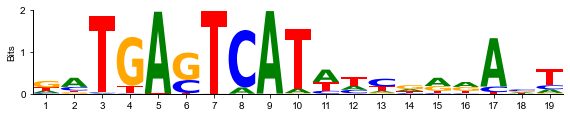

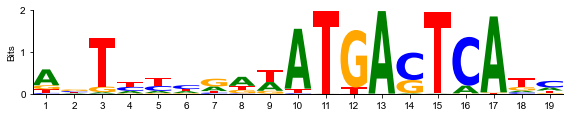

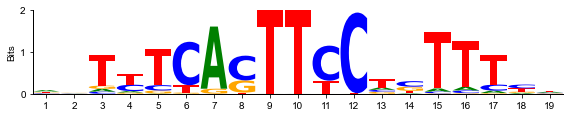

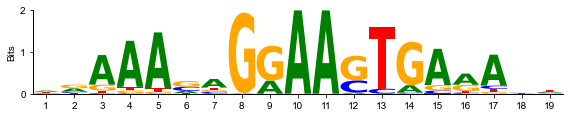

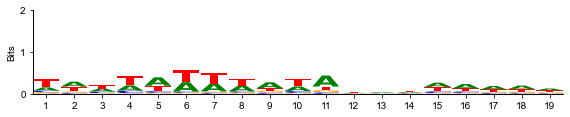

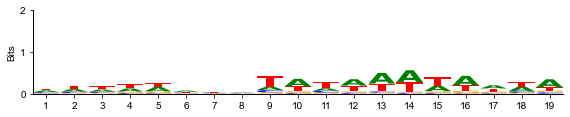

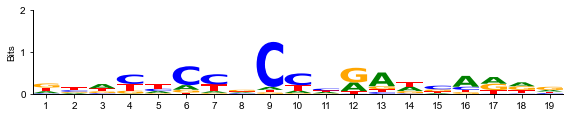

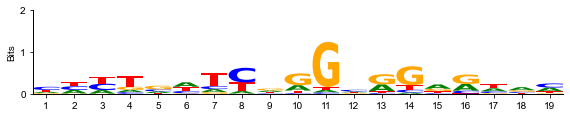

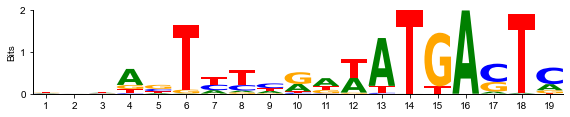

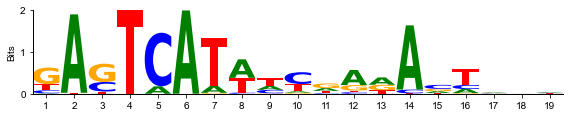

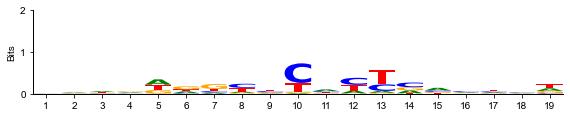

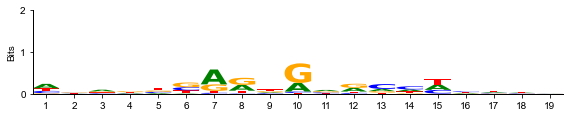

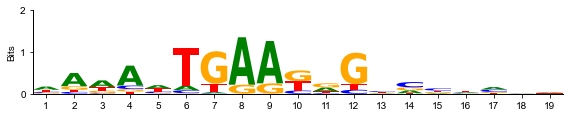

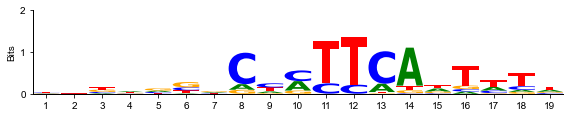

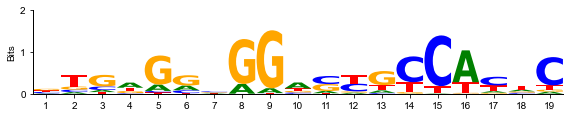

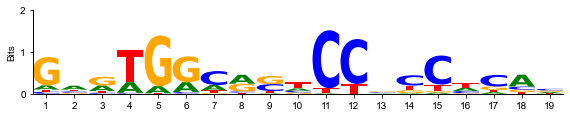

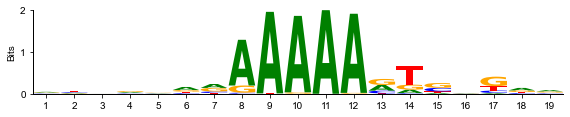

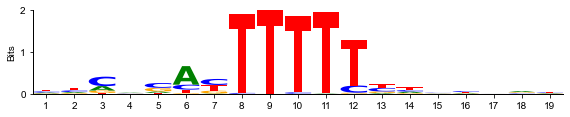

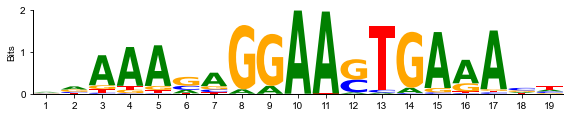

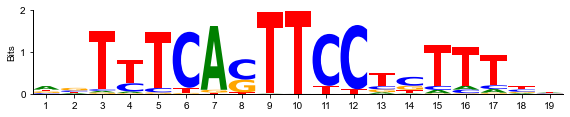

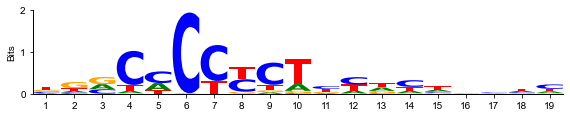

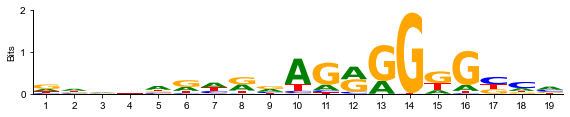

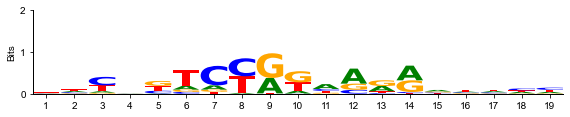

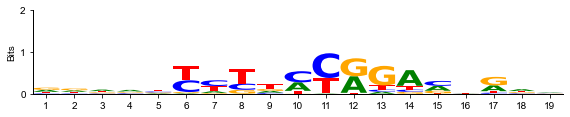

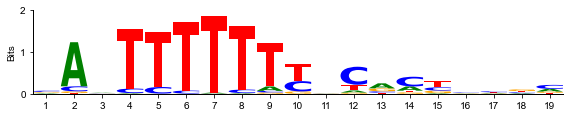

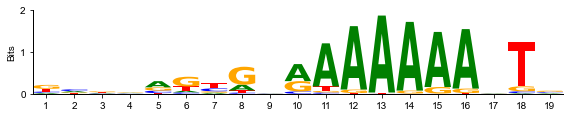

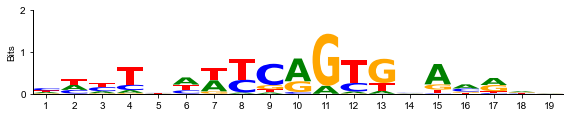

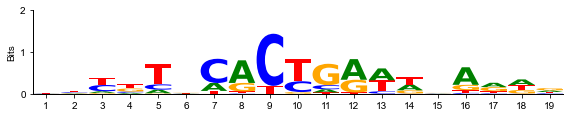

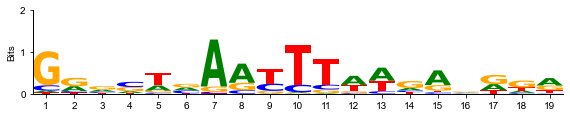

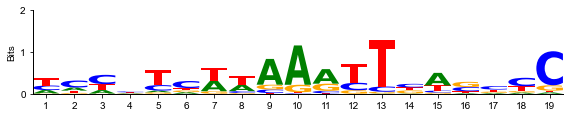

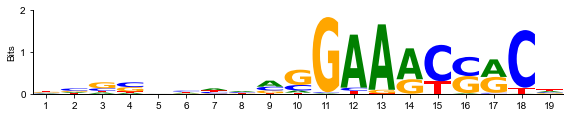

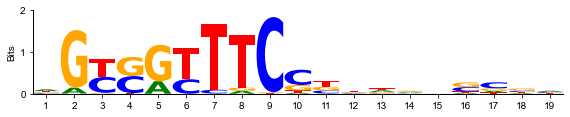

In [70]:
# For each filter, get the activation threshold (i.e. ≥50%)
thresholds = 0.5 * np.amax(activations["train"][idxs, :, :], axis=(0, 2))

# For each filter...
for i in tqdm(range(selene_dict["options"]["cnn_units"]),
              total=selene_dict["options"]["cnn_units"],
              bar_format=bar_format):

    # Get sites
    sites_file = os.path.join(output_dir, "sites",
        f"filter{i}.fa.gz")
    if not os.path.exists(sites_file):
        handle = __get_handle(sites_file, "wt")
        _get_sites(handle, idxs, seq_ids["train"], seqs["train"], activations["train"][:, i, :],
            thresholds[i], model._options["kernel_size"])
        handle.close()

    # Get motif
    motif_file = os.path.join(output_dir, "motifs",
        f"filter{i}.jaspar")
    if not os.path.exists(motif_file):
        handle = __get_handle(sites_file)
        motif = _get_motif(handle)
        handle.close()
        motif.matrix_id = f"filter{i}"
        motif.name = name
        handle = __get_handle(motif_file, "wt")
        handle.write(format(motif, "jaspar"))
        handle.close()
        jaspar_motifs.append(motif)

    # Get logos
    for reverse_complement in [False, True]:
        if reverse_complement:
            logo_file = os.path.join(output_dir, "logos",
                f"filter{i}.rev.png")
        else:
            logo_file = os.path.join(output_dir, "logos",
                f"filter{i}.fwd.png")
        if not os.path.exists(logo_file):
            fig = get_figure(motif_file, reverse_complement)
            fig.savefig(logo_file, bbox_inches="tight", pad_inches=0)

# Get motifs in MEME format
meme_file = os.path.join(output_dir, "motifs", "filters.meme")
if not os.path.exists(meme_file):
    reformat_motif(jaspar_motifs, "meme", meme_file)

# Get weights
weights_file = os.path.join(output_dir, "weights.tsv")
if not os.path.exists(weights_file):
    weights = model.final.weight.detach().cpu().numpy()
    handle = __get_handle(weights_file, "wt")
    for i, weight in enumerate(weights.T):
        s = "\t".join(map(str, weight))
        handle.write(f"filter{i}\t{s}\n")
    handle.close()

In [71]:
def _get_performances(handle, activations, ys, metric):
   
    # Initialize
    scores = []
    sum_activations = __split_arr_and_combine(activations, combine=True)
    ys = __split_arr_and_combine(ys)

    for y in ys.T:
        scores.append(metric(y, sum_activations))

    return(scores)

def __split_arr_and_combine(arr, combine=False):

    half_arr = arr[:len(arr)//2]
    other_half_arr = arr[len(arr)//2:]

    if combine:
        return(np.sum(np.concatenate((half_arr, other_half_arr), axis=1), axis=1))
    else:
        return(half_arr)

In [72]:
# Initialize
metrics = get_metrics(input_data=input_data)

# For each metric...
for m in metrics:

    # Get performances
    performance_file = os.path.join(output_dir, f"{m}.tsv")
    handle = __get_handle(performance_file, "wt")

    # For each filter...
    for i in tqdm(range(selene_dict["options"]["cnn_units"]),
                  total=selene_dict["options"]["cnn_units"],
                  bar_format=bar_format):

        # Get performances
        scores = _get_performances(handle, activations["validation"][:, i, :], ys["validation"],
                                   metrics[m])
        s = "\t".join(map(str, scores))
        handle.write(f"filter{i}\t{s}\n")

handle.close()

100%|████████████████████| 16/16 [00:00<00:00, 92.25it/s]
